## STM32 TFLM MNIST Demo

This example will perform character recognition through user input into the touch screen of an STM32 board using the MNIST dataset.


### Contributors

*Original Author: [Alex Hoffman](https://github.com/alxhoff)*

*Modifications by: [Philipp van Kempen](https://github.com/PhilippvK)*

### Code

Getting started with TF2 and MNIST dataset...

In [1]:
%tensorflow_version 2.x
!apt-get update
!apt-get install -y xxd

#! pip uninstall -y tensorflow
#! pip install -q tf-nightly
! pip install -q tensorflow-model-optimization

import tensorflow as tf
from tensorflow import keras

(images_train, labels_train), (images_test, labels_test) = tf.keras.datasets.mnist.load_data()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:12 https://developer.downlo

Display single sample from the MNIST dataset. It should be noted that the colors displayed here are in **inverted colors**.

3


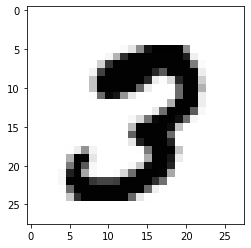

In [2]:
import matplotlib.pyplot as plt
test_index = 12345
print(labels_train[test_index])
plt.imshow(images_train[test_index], cmap='Greys')

The input of the neural network needs to know the input shape that it is going to be fed

In [3]:
input_shape = images_train.shape
print("{} images, each with shape of {} pixels x {} pixels".format(input_shape[0], input_shape[1], input_shape[2]))

60000 images, each with shape of 28 pixels x 28 pixels


The input shape for the model must be reshaped to 4D as the current shape does not show that each pixel is a 1D array where only the greyscale value (0-255) is stored. The input tensor's shape will be 3D as it will take a single-channel image. 

In [4]:
images_train = images_train.reshape(images_train.shape[0], images_train.shape[1], images_train.shape[2], 1)
images_test = images_test.reshape(images_test.shape[0], images_test.shape[1], images_test.shape[2], 1)
input_tensor_shape = (images_test.shape[1], images_test.shape[2], 1)
print("Input shape: {}".format(input_shape))

Input shape: (60000, 28, 28)


The greyscale values stores in the images' pixels are 8 bit values and need to be normalized into floats between 0-1.

In [5]:
images_train = images_train.astype('float32')
images_test = images_test.astype('float32')
images_train /= 255
images_test /= 255

Now the convolutional NN that we will use to classify the input images taken from the touch screen will have the following layer structure

1. Conv2D
2. MaxPooling2D
3. Flatten
4. Dense
5. Dropout
11. Dense



In [6]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

model = keras.Sequential()

model.add(keras.layers.Conv2D(28, kernel_size=(3,3), input_shape=input_tensor_shape))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(keras.layers.Dense(128, activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(10,activation=tf.nn.softmax))

model2 = keras.Sequential()

model2.add(keras.layers.Conv2D(12, kernel_size=(3,3), input_shape=input_tensor_shape))
model2.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(keras.layers.Flatten()) # Flattening the 2D arrays for fully connected layers
model2.add(keras.layers.Dense(10,activation=tf.nn.softmax))

model3 = keras.Sequential()

model3.add(keras.layers.Conv2D(12, kernel_size=(3,3), strides=(2,2), input_shape=input_tensor_shape))
model3.add(keras.layers.MaxPooling2D(pool_size=(3, 3)))
#model3.add(keras.layers.Flatten()) # Flattening the 2D arrays for fully connected layers
model3.add(keras.layers.Reshape((16,12,1)))
model3.add(keras.layers.MaxPooling2D(pool_size=(3, 3)))

#model3.add(keras.layers.MaxPooling1D(pool_size=6, padding='valid', data_format='channels_last'))
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(10,activation=tf.nn.softmax))

model4 = keras.Sequential()

model4.add(keras.layers.Conv2D(12, kernel_size=(3,3), strides=(2,2), input_shape=input_tensor_shape))
model4.add(keras.layers.Reshape( (13, 13, 12, 1)))
model4.add(keras.layers.MaxPooling3D(pool_size=(6, 3,3)))
model4.add(keras.layers.Flatten()) # Flattening the 2D arrays for fully connected layers
model4.add(keras.layers.Dense(10,activation=tf.nn.softmax))

model5 = keras.Sequential()

model5.add(keras.layers.Conv2D(12, kernel_size=(3,3), strides=(2,2), input_shape=input_tensor_shape))
model5.add(keras.layers.Reshape( (338, 6, 1)))
model5.add(keras.layers.MaxPooling2D(pool_size=(26, 3)))
model5.add(keras.layers.Flatten()) # Flattening the 2D arrays for fully connected layers
model5.add(keras.layers.Dense(10,activation=tf.nn.softmax))

quantized_model5 = quantize_model(model5)

The Conv2D layer extracts features from the input image using filters that slide across the input image. In this case we will use 28 different filters to extract a large number of unique features that will then be used to classify each image in the later layers. Thus the output of this layer will have the shape (28, 28, 1, 28)

MaxPooling2D is used to reduce the output size of the convolutional layer by reducing each 2 x 2 unique chunk of the output down in to a singular value, this reducing the output's size by a factor of 4. This will reduce our (28, 28, 1, 28) tensor down to a (7, 7, 1, 28) tensor.

The Flatten layer then takes this 2D array (our image) and shapes it into a single dimension (1372).

The following Dense layer reduces the input 1372 values down into 128 classes, taking the first steps in classifying the image into on of the 10 output classes (0-9). This is done using the relu activation function.

The Dropout layer sets 20% of the tensor's values to 0 so as to reduce overfitting.

Finally the last Dense layer reduces the output value down to the 10 classes, each representing a digit between 0 and 9. This is done using the softmax activation function which makes the outputs a set of probabilities summing to 1.


Train the model

In [7]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

quantized_model5.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 100
epochs = 10

print("Model 1")
history = model.fit(x=images_train,y=labels_train, epochs=epochs, batch_size=batch_size)
model.summary()

print("Model 2")
history2 = model2.fit(x=images_train,y=labels_train, epochs=epochs, batch_size=batch_size)
model2.summary()

print("Model 3")
history3 = model3.fit(x=images_train,y=labels_train, epochs=epochs, batch_size=batch_size)
model3.summary()

print("Model 4")
history4 = model4.fit(x=images_train,y=labels_train, epochs=epochs, batch_size=batch_size)
model4.summary()

print("Model 5")
history5 = model5.fit(x=images_train,y=labels_train, epochs=epochs, batch_size=batch_size)
model5.summary()

print("Model 5 Quantized")
history5_q = quantized_model5.fit(x=images_train,y=labels_train, epochs=epochs, batch_size=batch_size)
quantized_model5.summary()

Model 1
Epoch 1/10
600/600 [==============================] - 2s 3ms/step - loss: 0.2551 - accuracy: 0.9249
Epoch 2/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0955 - accuracy: 0.9710
Epoch 3/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0640 - accuracy: 0.9806
Epoch 4/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0476 - accuracy: 0.9855
Epoch 5/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0390 - accuracy: 0.9873
Epoch 6/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0284 - accuracy: 0.9906
Epoch 7/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0262 - accuracy: 0.9912
Epoch 8/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0214 - accuracy: 0.9933
Epoch 9/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0190 - accuracy: 0.9938
Epoch 10/10
600/600 [==============================] - 1s 2ms/step - loss: 0.0154 - accuracy

Now we can evaluate our trained model using the test data

In [8]:
res = model.evaluate(images_test, labels_test)
print("Model1 has an accuracy of {0:.2f}%".format(res[1] * 100))

res = model2.evaluate(images_test, labels_test)
print("Model2 has an accuracy of {0:.2f}%".format(res[1] * 100))

res = model3.evaluate(images_test, labels_test)
print("Model3 has an accuracy of {0:.2f}%".format(res[1] * 100))

res = model4.evaluate(images_test, labels_test)
print("Model4 has an accuracy of {0:.2f}%".format(res[1] * 100))

res = model5.evaluate(images_test, labels_test)
print("Model5 has an accuracy of {0:.2f}%".format(res[1] * 100))

res = quantized_model5.evaluate(images_test, labels_test)
print("Quantized model5 has an accuracy of {0:.2f}%".format(res[1] * 100))


313/313 [==============================] - 1s 2ms/step - loss: 0.0494 - accuracy: 0.9858
Model1 has an accuracy of 98.58%
313/313 [==============================] - 1s 2ms/step - loss: 0.0850 - accuracy: 0.9739
Model2 has an accuracy of 97.39%
313/313 [==============================] - 1s 2ms/step - loss: 0.4906 - accuracy: 0.8443
Model3 has an accuracy of 84.43%
313/313 [==============================] - 1s 2ms/step - loss: 0.4640 - accuracy: 0.8450
Model4 has an accuracy of 84.50%
313/313 [==============================] - 1s 2ms/step - loss: 0.6131 - accuracy: 0.8194
Model5 has an accuracy of 81.94%
313/313 [==============================] - 1s 2ms/step - loss: 0.6047 - accuracy: 0.8191
Quantized model5 has an accuracy of 81.91%


For the moment only `model2` is working in an acceptable way. The other models should be fixed in the future!

In [9]:
#best_model = quantized_model5
best_model = model2

The following is a workaround which can be removed in the future!

In [10]:
best_model.save('best_model.model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: best_model.model/assets


Now we will need to convert and save our model into a downloadable file that will be appropriate for a microcontroller. This is done using the TensorFlow Lite Converter. The `TFLITE_BUILTINS` option tells the converter to only use TensorFlow Lite built in operations.

In [11]:
converter = tf.lite.TFLiteConverter.from_saved_model('best_model.model')
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
tflite_model = converter.convert()

open("MNIST_model_no_optimizations.tflite", "wb").write(tflite_model)
!xxd -i MNIST_model_no_optimizations.tflite > MNIST_model_no_optimizations.cc


Now we will be running this model on a constrained device and as such we will need to perform quantization and optimizations to reduce the size of the model. The optimizations that TensorFlow offers are detailed [here](https://www.tensorflow.org/lite/performance/model_optimization). Also see [here](https://www.tensorflow.org/model_optimization/guide/quantization/training) for more information on quanitazation aware training and [here](https://www.tensorflow.org/lite/performance/post_training_quantization) for information on post-training quantization.

In [12]:
converter = tf.lite.TFLiteConverter.from_saved_model('best_model.model')
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open("MNIST_optimized_for_size.tflite", "wb").write(tflite_model)
!xxd -i MNIST_optimized_for_size.tflite > MNIST_optimized_for_size.cc

converter = tf.lite.TFLiteConverter.from_saved_model('best_model.model')
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

open("MNIST_default_optimizations.tflite", "wb").write(tflite_model)
!xxd -i MNIST_default_optimizations.tflite > MNIST_default_optimizations.cc

These optimizations reduced the file size significantly but we can do better. Enforcing full integer quantization for all operations as well as ensuring all model math is quantized to 8-bit. Doing so requires a representative dataset that can be used to evaluate optimizations made by the converter. The representative dataset must be a python iterator.

**Warning:**

To remove all `Quantize` nodes from the graph (which currently do not support `uint8`) signed 8-bit integers have to be used for inputs and outputs!

In [13]:
import numpy as np

def representative_dataset_gen():
  for image in images_test:
    array = np.array(image)
    array = np.expand_dims(array, axis = 0)
    yield ([array])

converter = tf.lite.TFLiteConverter.from_saved_model('best_model.model')
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()

open("MNIST_full_quanitization.tflite", "wb").write(tflite_model)
!xxd -i MNIST_full_quanitization.tflite > MNIST_full_quanitization.cc

This file needs to now be included in our microcontroller project and as such must be in a form that is easily usable on a device without a file system. xxd can be used to convert the model into a C source file where the model is stored as a byte array.

In [14]:
!xxd -i MNIST_full_quanitization.tflite > MNIST_full_quanitization.cc
!cat MNIST_full_quanitization.cc

unsigned char MNIST_full_quanitization_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x12, 0x00,
  0x1c, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00,
  0x00, 0x00, 0x18, 0x00, 0x12, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x00, 0x5d, 0x00, 0x00, 0x88, 0x51, 0x00, 0x00, 0x70, 0x51, 0x00, 0x00,
  0x3c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x04, 0x00, 0x08, 0x00,
  0x08, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f, 0x72, 0x75, 0x6e, 0x74,
  0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73, 0x69, 0x6f, 0x6e, 0x00,
  0x0d, 0x00, 0x00, 0x00, 0x1c, 0x51, 0x00, 0x00, 0x08, 0x51, 0x00, 0x00,
  0xec, 0x50, 0x00, 0x00, 0xa8, 0x50, 0x00, 0x00, 0x54, 0x01, 0x00, 0x00,
  0xd0, 0x00, 0x00, 0x00, 0x8c, 0x00, 0x00, 0x00, 0x80, 0x00, 0x00, 0x00,
  0x6c, 0x00, 0x00, 0x00, 0x58, 0x00, 0x00, 0x00, 0x44, 0x00

This file is downloadable from the left hand menu of colab. Although this file is too large to be used as a model on a microcontroller. We will have to do some more optimizations.

Pruning is where unncessary values in weight tensors are removed, thus reducing the number of parameters needed to store the model. This is done by further training the model while intermittently running pruning code that removes unnecessary connections between the layers of the neuran network.

In [15]:
!pip install -q tensorflow-model-optimization

import numpy as np 
import os
from tensorflow_model_optimization.sparsity import keras as sparsity

end_step = np.ceil(1.0 * images_train.shape[0] / batch_size).astype(np.int32) * epochs
print(end_step)

pruning_params = {
    'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.5,
                                                 final_sparsity=0.9,
                                                 begin_step=0,
                                                 end_step=end_step,
                                                 frequency=100
                                                 )
}

new_pruned_model = sparsity.prune_low_magnitude(best_model, **pruning_params)
new_pruned_model.summary()

new_pruned_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [sparsity.UpdatePruningStep(),sparsity.PruningSummaries(log_dir=os.path.abspath(os.getcwd()), profile_batch=0)]

new_pruned_model.fit(images_train, labels_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=1,
                     callbacks=callbacks)

score = new_pruned_model.evaluate(images_test, labels_test, verbose=0)
print("Test loss: {}".format(score[0]))
print("Test accuracy: {}".format(score[1]))

6000
Instructions for updating:
Please use `layer.add_weight` method instead.


Instructions for updating:
Please use `layer.add_weight` method instead.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d_1 (None, 26, 26, 12)        230       
_________________________________________________________________
prune_low_magnitude_max_pool (None, 13, 13, 12)        1         
_________________________________________________________________
prune_low_magnitude_flatten_ (None, 2028)              1         
_________________________________________________________________
prune_low_magnitude_dense_2  (None, 10)                40572     
Total params: 40,804
Trainable params: 20,410
Non-trainable params: 20,394
_________________________________________________________________
Epoch 1/10
600/600 [==============================] - 3s 5ms/step - loss: 0.0860 - accuracy: 0.9759
Epoch 2/10
600/600 [==============================] - 3s 5ms/step - loss: 0.0898 - accuracy: 0.9742
Epoch 3/10
600/600 [=======================

Now we can export the pruned model

In [16]:
new_pruned_model.summary()
best_model_pruned = sparsity.strip_pruning(new_pruned_model)
best_model_pruned.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d_1 (None, 26, 26, 12)        230       
_________________________________________________________________
prune_low_magnitude_max_pool (None, 13, 13, 12)        1         
_________________________________________________________________
prune_low_magnitude_flatten_ (None, 2028)              1         
_________________________________________________________________
prune_low_magnitude_dense_2  (None, 10)                40572     
Total params: 40,804
Trainable params: 20,410
Non-trainable params: 20,394
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 12)        120       
_______________________

We can compare each pruned weight against zero to see how many weights were pruned out of the model

In [17]:
from tensorflow.keras.models import load_model

import numpy as np

for i, w in enumerate(best_model_pruned.get_weights()):
    print("{} -- Total:{}, Zeros: {:.2f}%".format(
        model.weights[i].name, w.size, np.sum(w == 0) / w.size * 100 ))

conv2d/kernel:0 -- Total:108, Zeros: 89.81%
conv2d/bias:0 -- Total:12, Zeros: 0.00%
dense/kernel:0 -- Total:20280, Zeros: 90.00%
dense/bias:0 -- Total:10, Zeros: 0.00%


Same as before we can quantize the model, convert and save

In [18]:
# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(best_model_pruned)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()

# Save the model to disk
open("MNIST_pruned.tflite", "wb").write(tflite_model)
!xxd -i MNIST_pruned.tflite > MNIST_pruned.cc

INFO:tensorflow:Assets written to: /tmp/tmpjxyqdsdw/assets


INFO:tensorflow:Assets written to: /tmp/tmpjxyqdsdw/assets


Puning saved us

In [19]:
print("Quanized file size difference is: {} bytes".format(os.path.getsize("MNIST_model_no_optimizations.tflite") - os.path.getsize("MNIST_full_quanitization.tflite")))
print("Pruned file size difference is: {} bytes".format(os.path.getsize("MNIST_full_quanitization.tflite") - os.path.getsize("MNIST_pruned.tflite")))

Quanized file size difference is: 60132 bytes
Pruned file size difference is: 64 bytes


As the generated models are so large we need to make sure they are stored in the .rodata segment. To do so the model must be prefixed extern const such that it does not land in the .data segment and kill our ram. 

Currently only `MNIST_full_quanitization.tflite` is relevant for deployment, comment-in the others if required.

In [21]:
!sed -i '1s/^/extern const /' MNIST_full_quanitization.cc
!sed -i '$s/^/extern const /' MNIST_full_quanitization.cc
#!sed -i '1s/^/extern const /' MNIST_model_no_optimizations.cc
#!sed -i '$s/^/extern const /' MNIST_model_no_optimizations.cc
#!sed -i '1s/^/extern const /' MNIST_default_optimizations.cc
#!sed -i '$s/^/extern const /' MNIST_default_optimizations.cc
#!sed -i '1s/^/extern const /' MNIST_optimized_for_size.cc
#!sed -i '$s/^/extern const /' MNIST_optimized_for_size.cc
#!sed -i '1s/^/extern const /' MNIST_pruned.cc
#!sed -i '$s/^/extern const /' MNIST_pruned.cc